In [1]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Reading in the Data

- counts for all species at MVCO

In [77]:
df = pd.read_csv("/D/MIT-WHOI/data/2021/adhoc50/count_by_class_time_series_CNN_daily12Oct2021.csv")
df.head()

datetime  milliliters_analyzed  Acanthoica_quattrospina  \
0  06-Jun-2006 21:26:01             53.264397                        1   
1  07-Jun-2006 11:58:20            244.068262                      131   
2  08-Jun-2006 12:30:33            202.754723                       81   
3  09-Jun-2006 07:29:59            145.061916                       42   
4  10-Jun-2006 15:24:26            169.446014                       56   

   Akashiwo  Alexandrium_catenella  Amphidinium  Amylax  Apedinella  \
0         0                      0            0       0           3   
1         0                      3            5       2          78   
2         0                      0            1       3          70   
3         0                      0            2       0          26   
4         0                      0            1       3          34   

   Asterionellopsis_glacialis  Bacillaria  ...     mix  pennate  \
0                           1           0  ...    3106       18   
1                          52           1  ...  137410      712   
2                          28           0  ...  206543      741   
3                          11           1  ...  128360      597   
4                          18           1  ...  134008      750   

   pennate_Pseudo-nitzschia  pennate_Thalassionema  pennate_morphotype1  \
0                         0                      0                    0   
1                        13                      0                    1   
2                         8                      2                    1   
3                         2                      0                    5   
4                         3                      0                    2   

   pollen  shellfish_larvae  square_unknown  unknown2  zooplankton  
0       0                 0               0         0            1  
1       0                 0              34        10            2  
2       0                 0              67        11            3  
3       1                 1              42         1            0  
4       1                 0              50         0            0  

[5 rows x 157 columns]

### Converting to long format and Grouping by functional group (Dinoflagellate, Diatom, Ciliate, Coccolithophore)

In [83]:
df.long = df.melt(id_vars = ['datetime','milliliters_analyzed'],var_name = "species",value_name="count")#converting from wide to long
df.long["datetime"] = pd.to_datetime(df.long["datetime"],format='%d-%b-%Y %H:%M:%S')

print(df.long.head())
clist = pd.read_csv('/D/MIT-WHOI/data/2021/IFCB_classlist_type.csv') #importing classlist type maps species to functional groups e.g. diatoms, dinoflagellates
clist.long = pd.melt(clist,id_vars = ['CNN_classlist'], var_name = 'group',value_name='present') #converting to long version
clist.long = clist.long.rename(columns = {"CNN_classlist":'species','in_out':'present'}) #renaming columns to species and presense
clist.long = clist.long[clist.long['present']==1] #isolating present
clist.long.head()

df.long = df.long.join(clist.long.set_index('species'),on = 'species')
print(df.long.group.unique())
print(df.long.head())
df.grouped = df.long.groupby(['datetime','group']).sum().reset_index()
df.grouped["count/mL"]=df.grouped["count"]/df.grouped["milliliters_analyzed"]
df.grouped

             datetime  milliliters_analyzed                  species  count
0 2006-06-06 21:26:01             53.264397  Acanthoica_quattrospina      1
1 2006-06-07 11:58:20            244.068262  Acanthoica_quattrospina    131
2 2006-06-08 12:30:33            202.754723  Acanthoica_quattrospina     81
3 2006-06-09 07:29:59            145.061916  Acanthoica_quattrospina     42
4 2006-06-10 15:24:26            169.446014  Acanthoica_quattrospina     56
['Coccolithophore' 'Nano' 'Dinoflagellate' 'flagellate' 'Diatom'
 'pennatediatom' 'Ciliate' 'Other live' 'IFCB artifact' 'Other not alive'
 nan]
             datetime  milliliters_analyzed                  species  count  \
0 2006-06-06 21:26:01             53.264397  Acanthoica_quattrospina      1   
0 2006-06-06 21:26:01             53.264397  Acanthoica_quattrospina      1   
1 2006-06-07 11:58:20            244.068262  Acanthoica_quattrospina    131   
1 2006-06-07 11:58:20            244.068262  Acanthoica_quattrospina    131   
2 20

datetime            group  milliliters_analyzed   count  \
0     2006-06-06 21:26:01          Ciliate           1491.403113      35   
1     2006-06-06 21:26:01  Coccolithophore            426.115175      11   
2     2006-06-06 21:26:01           Diatom           2929.541829     503   
3     2006-06-06 21:26:01   Dinoflagellate           1491.403113     714   
4     2006-06-06 21:26:01    IFCB artifact            159.793191    1556   
...                   ...              ...                   ...     ...   
42775 2021-08-27 08:14:13             Nano           2286.904398   14392   
42776 2021-08-27 08:14:13       Other live           1524.602932    4255   
42777 2021-08-27 08:14:13  Other not alive            762.301466  115990   
42778 2021-08-27 08:14:13       flagellate           2439.364691    5546   
42779 2021-08-27 08:14:13    pennatediatom           1829.523518    1746   

       present    count/mL  
0         28.0    0.023468  
1          8.0    0.025815  
2         55.0    0.171699  
3         28.0    0.478744  
4          3.0    9.737586  
...        ...         ...  
42775     15.0    6.293223  
42776     10.0    2.790891  
42777      5.0  152.157650  
42778     16.0    2.273543  
42779     12.0    0.954347  

[42780 rows x 6 columns]

### Reading in Temperature data

In [86]:
dftemp = pd.read_csv("/D/MIT-WHOI/data/2021/temp_total.csv",header = None)
dftemp_time = pd.read_csv("/D/MIT-WHOI/data/2021/temp_total_time_num.csv", header = None)

dftemp = pd.concat([dftemp[col] for col in dftemp]) # data comes in as 366 x 12 column. flattening to get 1 data column 
dftemp_time = pd.concat([dftemp_time[col] for col in dftemp_time]) #also flattening for time column 
dftemp_time_conv = pd.to_datetime(dftemp_time, format='%Y%m%d', errors='ignore')
# dftemp.head()
# dftemp_time_conv.head()

dft = pd.concat([dftemp_time_conv,dftemp],axis =1) #combining into one dataframe with just datetime and temperature
dft = dft.rename(columns={0: "datetime", 1: "temp"}) #
dft['datetime'] = pd.to_datetime(dft['datetime'], format = '%Y-%m-%d')
dft.head()
dft.shape

df.longtemp = df.grouped.copy()
year = pd.to_numeric(df.longtemp["datetime"].dt.year)
doy = pd.to_numeric(df.longtemp["datetime"].dt.dayofyear).div(365)
df.longtemp["yearday"] = year + doy
df.longtemp["year"] = year
df.longtemp["month"] = pd.to_numeric(df.longtemp["datetime"].dt.month)
df.longtemp['datetime'] = df.longtemp['datetime'].dt.date
df.longtemp['datetime'] = pd.to_datetime(df.longtemp['datetime'], format = '%Y-%m-%d')
df.longtemp.head()
dftotal = pd.merge(df.longtemp,dft, how = "outer", on = "datetime").dropna(axis = 0)
dftotal.head()
# dftotal.shape
# dftotalgrouped = dftotal.groupby(['datetime','group']).sum().reset_index()
# dftotalgrouped["count/mL"]=df.grouped["count"]/df.grouped["milliliters_analyzed"]
# dftotalgrouped

datetime            group  milliliters_analyzed   count  present  \
0 2006-06-06          Ciliate           1491.403113    35.0     28.0   
1 2006-06-06  Coccolithophore            426.115175    11.0      8.0   
2 2006-06-06           Diatom           2929.541829   503.0     55.0   
3 2006-06-06   Dinoflagellate           1491.403113   714.0     28.0   
4 2006-06-06    IFCB artifact            159.793191  1556.0      3.0   

   count/mL      yearday    year  month    temp  
0  0.023468  2006.430137  2006.0    6.0  14.518  
1  0.025815  2006.430137  2006.0    6.0  14.518  
2  0.171699  2006.430137  2006.0    6.0  14.518  
3  0.478744  2006.430137  2006.0    6.0  14.518  
4  9.737586  2006.430137  2006.0    6.0  14.518

Text(0.5, 1.0, 'Temperature over Time')

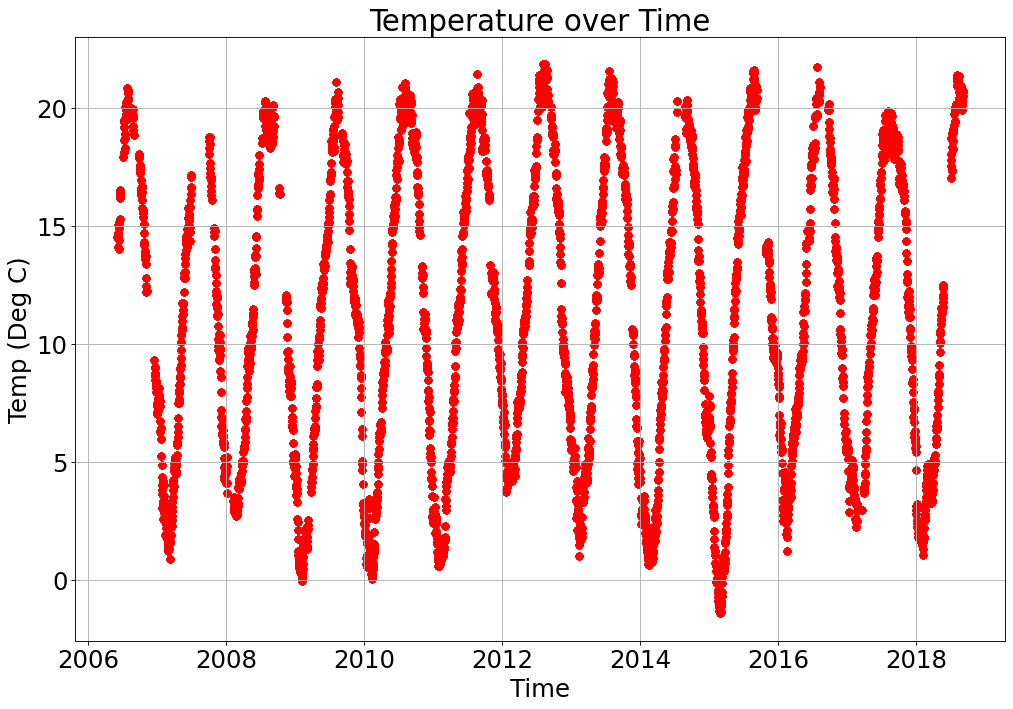

In [103]:
plt.figure(figsize=(15, 10), dpi=80)
plt.scatter(dftotal["datetime"],dftotal["temp"],c="r")
plt.grid()
plt.xlabel("Time")
plt.ylabel("Temp (Deg C)")
plt.title("Temperature over Time")


### Aggregating all living things into one aggregate dataframe

In [96]:
#aggregating all living things
df_live = df.grouped[df.grouped['group'].isin(['Coccolithophore','Nano','Dinoflagellate','flagellate','Diatom','pennatediatom','Ciliate','Other live'])]
df_live = df_live.groupby('datetime').sum().reset_index()
df_live["count/mL"]=df_live["count"]/df_live["milliliters_analyzed"]
df_live = df_live[['datetime','count/mL']]
df_live["datetime"] = pd.to_datetime(df_live["datetime"],format='%d-%b-%Y %H:%M:%S')
df_live.rename(columns = {'datetime':'ds','count/mL':'y'}, inplace = True)
df_live.head()

ds         y
0 2006-06-06 21:26:01  0.821811
1 2006-06-07 11:58:20  5.743628
2 2006-06-08 12:30:33  9.034774
3 2006-06-09 07:29:59  7.374077
4 2006-06-10 15:24:26  6.800204

### Plotting Aggregate Concentration over Time

datetime  milliliters_analyzed                  species  count  \
0 2006-06-06             53.264397  Acanthoica_quattrospina    1.0   
1 2006-06-06             53.264397  Acanthoica_quattrospina    1.0   
2 2006-06-06             53.264397                 Akashiwo    0.0   
3 2006-06-06             53.264397    Alexandrium_catenella    0.0   
4 2006-06-06             53.264397              Amphidinium    0.0   

             group  present      yearday    year  month    temp  
0  Coccolithophore      1.0  2006.430137  2006.0    6.0  14.518  
1             Nano      1.0  2006.430137  2006.0    6.0  14.518  
2   Dinoflagellate      1.0  2006.430137  2006.0    6.0  14.518  
3   Dinoflagellate      1.0  2006.430137  2006.0    6.0  14.518  
4   Dinoflagellate      1.0  2006.430137  2006.0    6.0  14.518

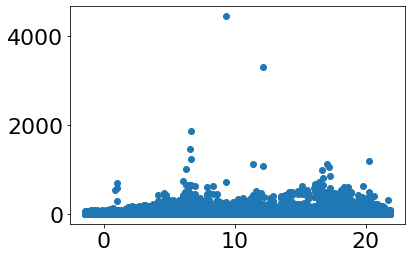

In [94]:
plt.scatter(dftotal["temp"],dftotal["count/mL"])

(0.0, 60.0)

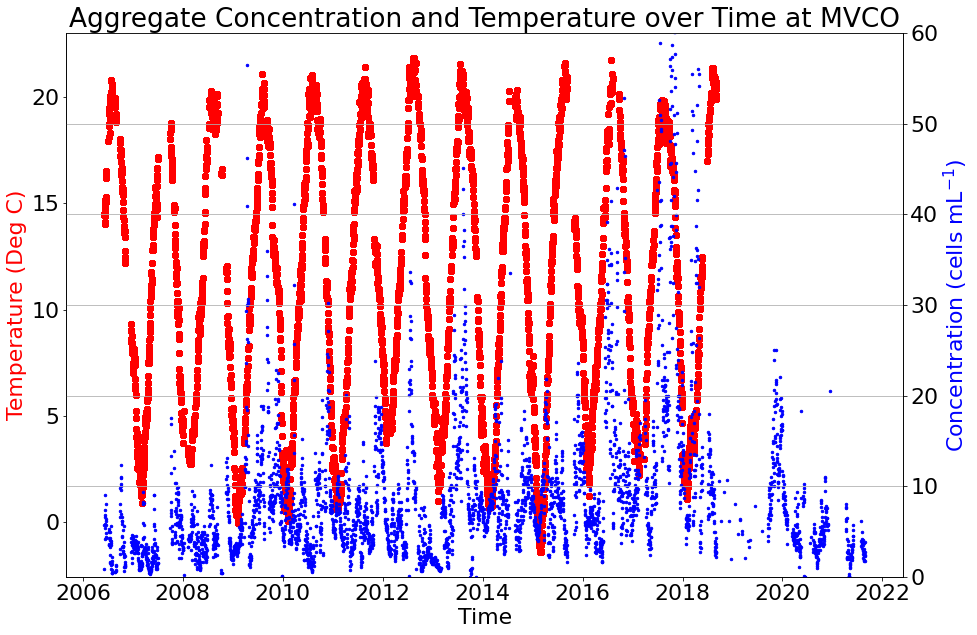

In [119]:
font = {'weight':'normal','size': 22}

plt.rc('font',**font)

fig, ax1 = plt.subplots(figsize = (15,10))

ax2 = ax1.twinx()
# ax1.plot(x, y1, 'g-')
# ax2.plot(x, y2, 'b-')

ax1.set_xlabel('Time')
ax1.scatter(dftotal["datetime"],dftotal["temp"],c="r")
ax2.scatter(df_live.ds,df_live.y,s = 6,marker = 'o',c = "b")
plt.grid()
# plt.ylabel("count/mL")
ax1.set_ylabel('Temperature (Deg C)', color='r')
ax2.set_ylabel('Concentration (cells mL$^{-1}$)', color='b')
plt.title("Aggregate Concentration and Temperature over Time at MVCO")
plt.ylim(0,60)

In [121]:
df_diatom = df.grouped[df.grouped.group == 'Diatom'][['datetime','count/mL']] #isolating diatoms
df_diatom["datetime"] = pd.to_datetime(df_diatom["datetime"],format='%d-%b-%Y %H:%M:%S')
df_diatom.rename(columns = {'datetime':'ds','count/mL':'y'}, inplace = True)
df_diatom.head()

df_dinoflagellate = df.grouped[df.grouped.group == 'Dinoflagellate'][['datetime','count/mL']] #isolating dinoflagellates
df_dinoflagellate["datetime"] = pd.to_datetime(df_dinoflagellate["datetime"],format='%d-%b-%Y %H:%M:%S')
df_dinoflagellate.rename(columns = {'datetime':'ds','count/mL':'y'}, inplace = True)
df_dinoflagellate.head()

df_ciliate = df.grouped[df.grouped.group == 'Ciliate'][['datetime','count/mL']] #isolating ciliates
df_ciliate["datetime"] = pd.to_datetime(df_ciliate["datetime"],format='%d-%b-%Y %H:%M:%S')
df_ciliate.rename(columns = {'datetime':'ds','count/mL':'y'}, inplace = True)
df_ciliate.head()

df_coccolithophore = df.grouped[df.grouped.group == 'Coccolithophore'][['datetime','count/mL']] #isolating coccolithophores
df_coccolithophore["datetime"] = pd.to_datetime(df_coccolithophore["datetime"],format='%d-%b-%Y %H:%M:%S')
df_coccolithophore.rename(columns = {'datetime':'ds','count/mL':'y'}, inplace = True)
df_coccolithophore.head()

ds         y
1  2006-06-06 21:26:01  0.025815
11 2006-06-07 11:58:20  0.611509
21 2006-06-08 12:30:33  0.470396
31 2006-06-09 07:29:59  0.505818
41 2006-06-10 15:24:26  0.438930

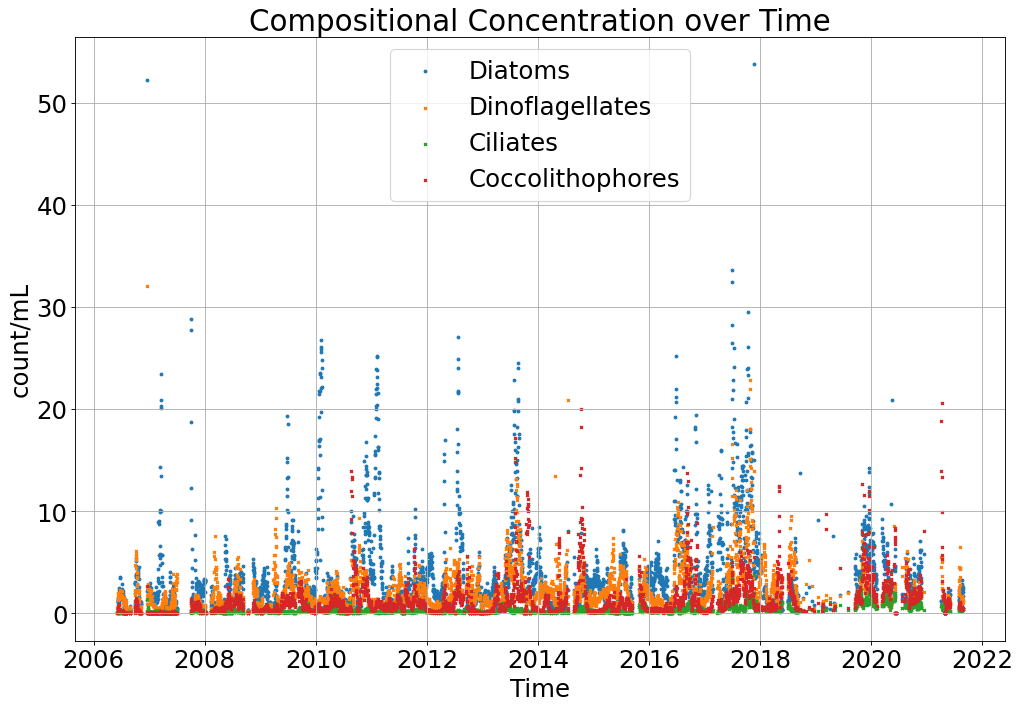

In [189]:
font = {'weight':'normal','size': 22}

plt.rc('font',**font)

plt.figure(figsize=(15, 10), dpi=80)
plt.scatter(df_diatom.ds,df_diatom.y,s = 6,marker = 'o')
plt.scatter(df_dinoflagellate.ds,df_dinoflagellate.y,s = 6, marker = 'x')
plt.scatter(df_ciliate.ds,df_ciliate.y,s = 6, marker = 'x')
plt.scatter(df_coccolithophore.ds,df_coccolithophore.y,s = 6, marker = 'x')

plt.grid()
plt.xlabel("Time")
plt.ylabel("count/mL")
plt.title("Compositional Concentration over Time")
plt.legend(["Diatoms","Dinoflagellates","Ciliates","Coccolithophores"])

(0.0, 60.0)

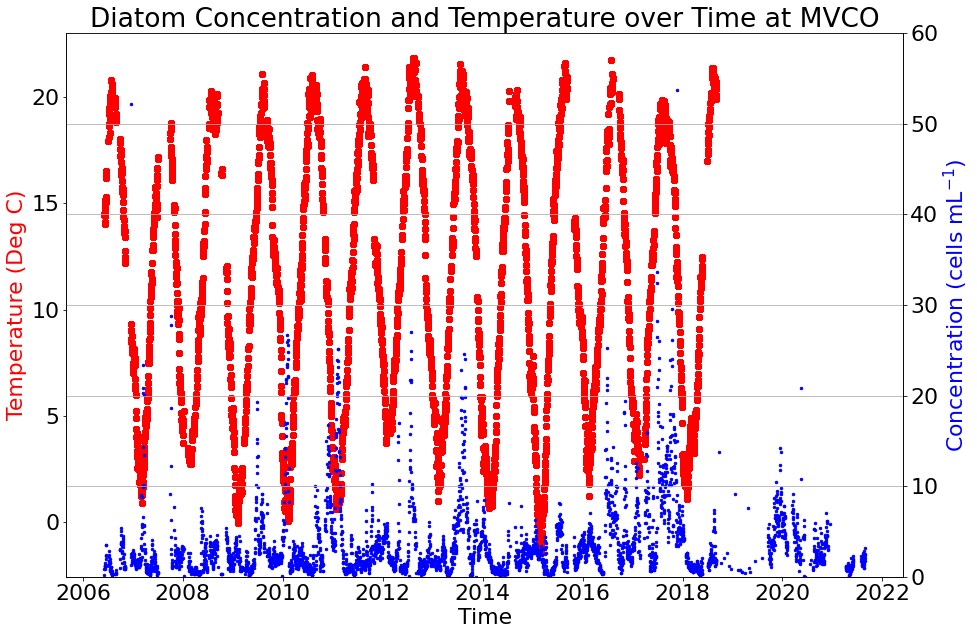

In [148]:
font = {'weight':'normal','size': 22}

plt.rc('font',**font)

fig, ax1 = plt.subplots(figsize = (15,10))

ax2 = ax1.twinx()
# ax1.plot(x, y1, 'g-')
# ax2.plot(x, y2, 'b-')

ax1.set_xlabel('Time')
ax1.scatter(dftotal["datetime"],dftotal["temp"],c="r")
ax2.scatter(df_diatom.ds,df_diatom.y,s = 6,marker = 'o',c = "b")
plt.grid()
# plt.ylabel("count/mL")
ax1.set_ylabel('Temperature (Deg C)', color='r')
ax2.set_ylabel('Concentration (cells mL$^{-1}$)', color='b')
plt.title("Diatom Concentration and Temperature over Time at MVCO")
plt.ylim(0,60)

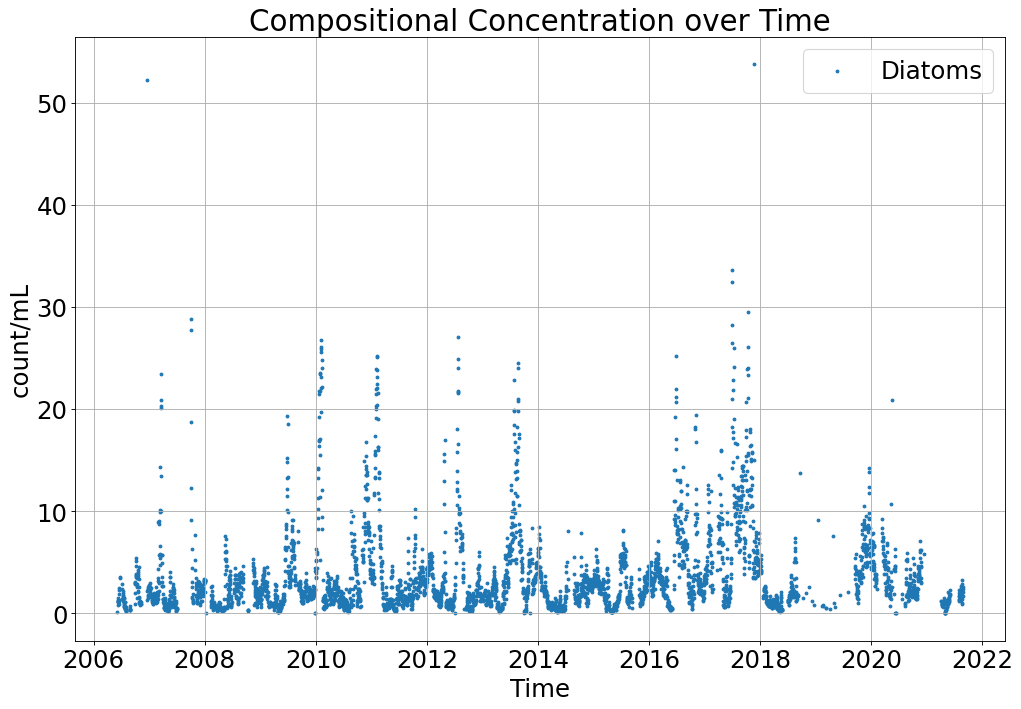

In [183]:
font = {'weight':'normal','size': 22}

plt.rc('font',**font)

plt.figure(figsize=(15, 10), dpi=80)
plt.scatter(df_diatom.ds,df_diatom.y,s = 6,marker = 'o')
# plt.scatter(df_dinoflagellate.ds,df_dinoflagellate.y,s = 6, marker = 'x')
# plt.scatter(df_ciliate.ds,df_ciliate.y,s = 6, marker = 'x')
# plt.scatter(df_coccolithophore.ds,df_coccolithophore.y,s = 6, marker = 'x')

plt.grid()
plt.xlabel("Time")
plt.ylabel("count/mL")
plt.title("Compositional Concentration over Time")
plt.legend(["Diatoms","Dinoflagellates","Ciliates","Coccolithophores"])

In [130]:
df_diatom["ds"].dtype

dtype('<M8[ns]')

In [135]:
#set date range
start_date = '2003-01-01 00:00:00'
end_date = '2014-01-01 00:00:00'

mask = (df_diatom['ds'] >= start_date) & (df_diatom['ds'] <= end_date)
df_diatom.loc[mask]

ds         y
2     2006-06-06 21:26:01  0.171699
12    2006-06-07 11:58:20  0.814452
22    2006-06-08 12:30:33  1.500425
32    2006-06-09 07:29:59  1.284467
42    2006-06-10 15:24:26  1.233109
...                   ...       ...
23342 2013-12-26 11:55:26  4.715340
23352 2013-12-27 12:05:24  4.714231
23362 2013-12-28 04:00:02  5.025076
23372 2013-12-30 21:59:15  6.043265
23382 2013-12-31 09:59:31  5.734418

[2339 rows x 2 columns]

In [137]:
#  m = Prophet(mcmc_samples = 300)

m = Prophet(weekly_seasonality=False)
m.add_seasonality(name='season', period=90, fourier_order=5)
m.fit(df_diatom.loc[mask])

future = m.make_future_dataframe(periods=90)
future.tail()

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

Initial log joint probability = -10.2841
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4950.56    0.00153479       252.585      0.3976      0.3976      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4954.12   0.000304801       74.0443           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4956.19   0.000155453       67.1859      0.7328      0.7328      363   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        4956.6   0.000334065       56.8141       1.184      0.4812      482   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     403        4956.6    3.5012e-06        52.374   5.954e-08       0.001      541  LS failed, Hessian reset 
     499       4956.76   3.25192e-05    

ds      yhat  yhat_lower  yhat_upper
2424 2014-03-27 09:59:31  4.236505   -0.312751    9.131946
2425 2014-03-28 09:59:31  4.222737   -0.582147    9.234782
2426 2014-03-29 09:59:31  4.205258   -0.530713    8.662261
2427 2014-03-30 09:59:31  4.187418   -0.497082    8.707961
2428 2014-03-31 09:59:31  4.173014   -0.595642    8.731199

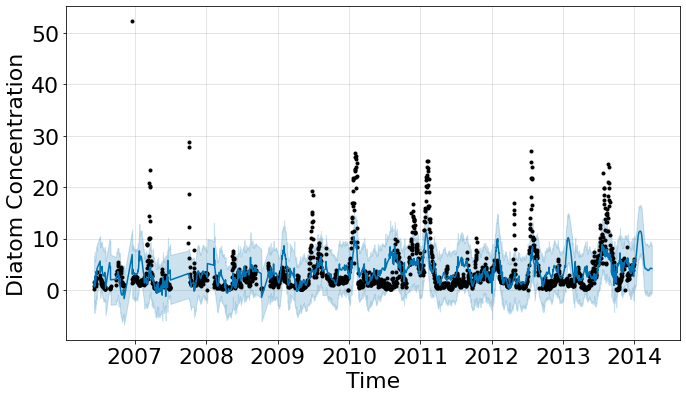

In [145]:
fig1= m.plot(forecast,xlabel="Time",ylabel='Diatom Concentration')

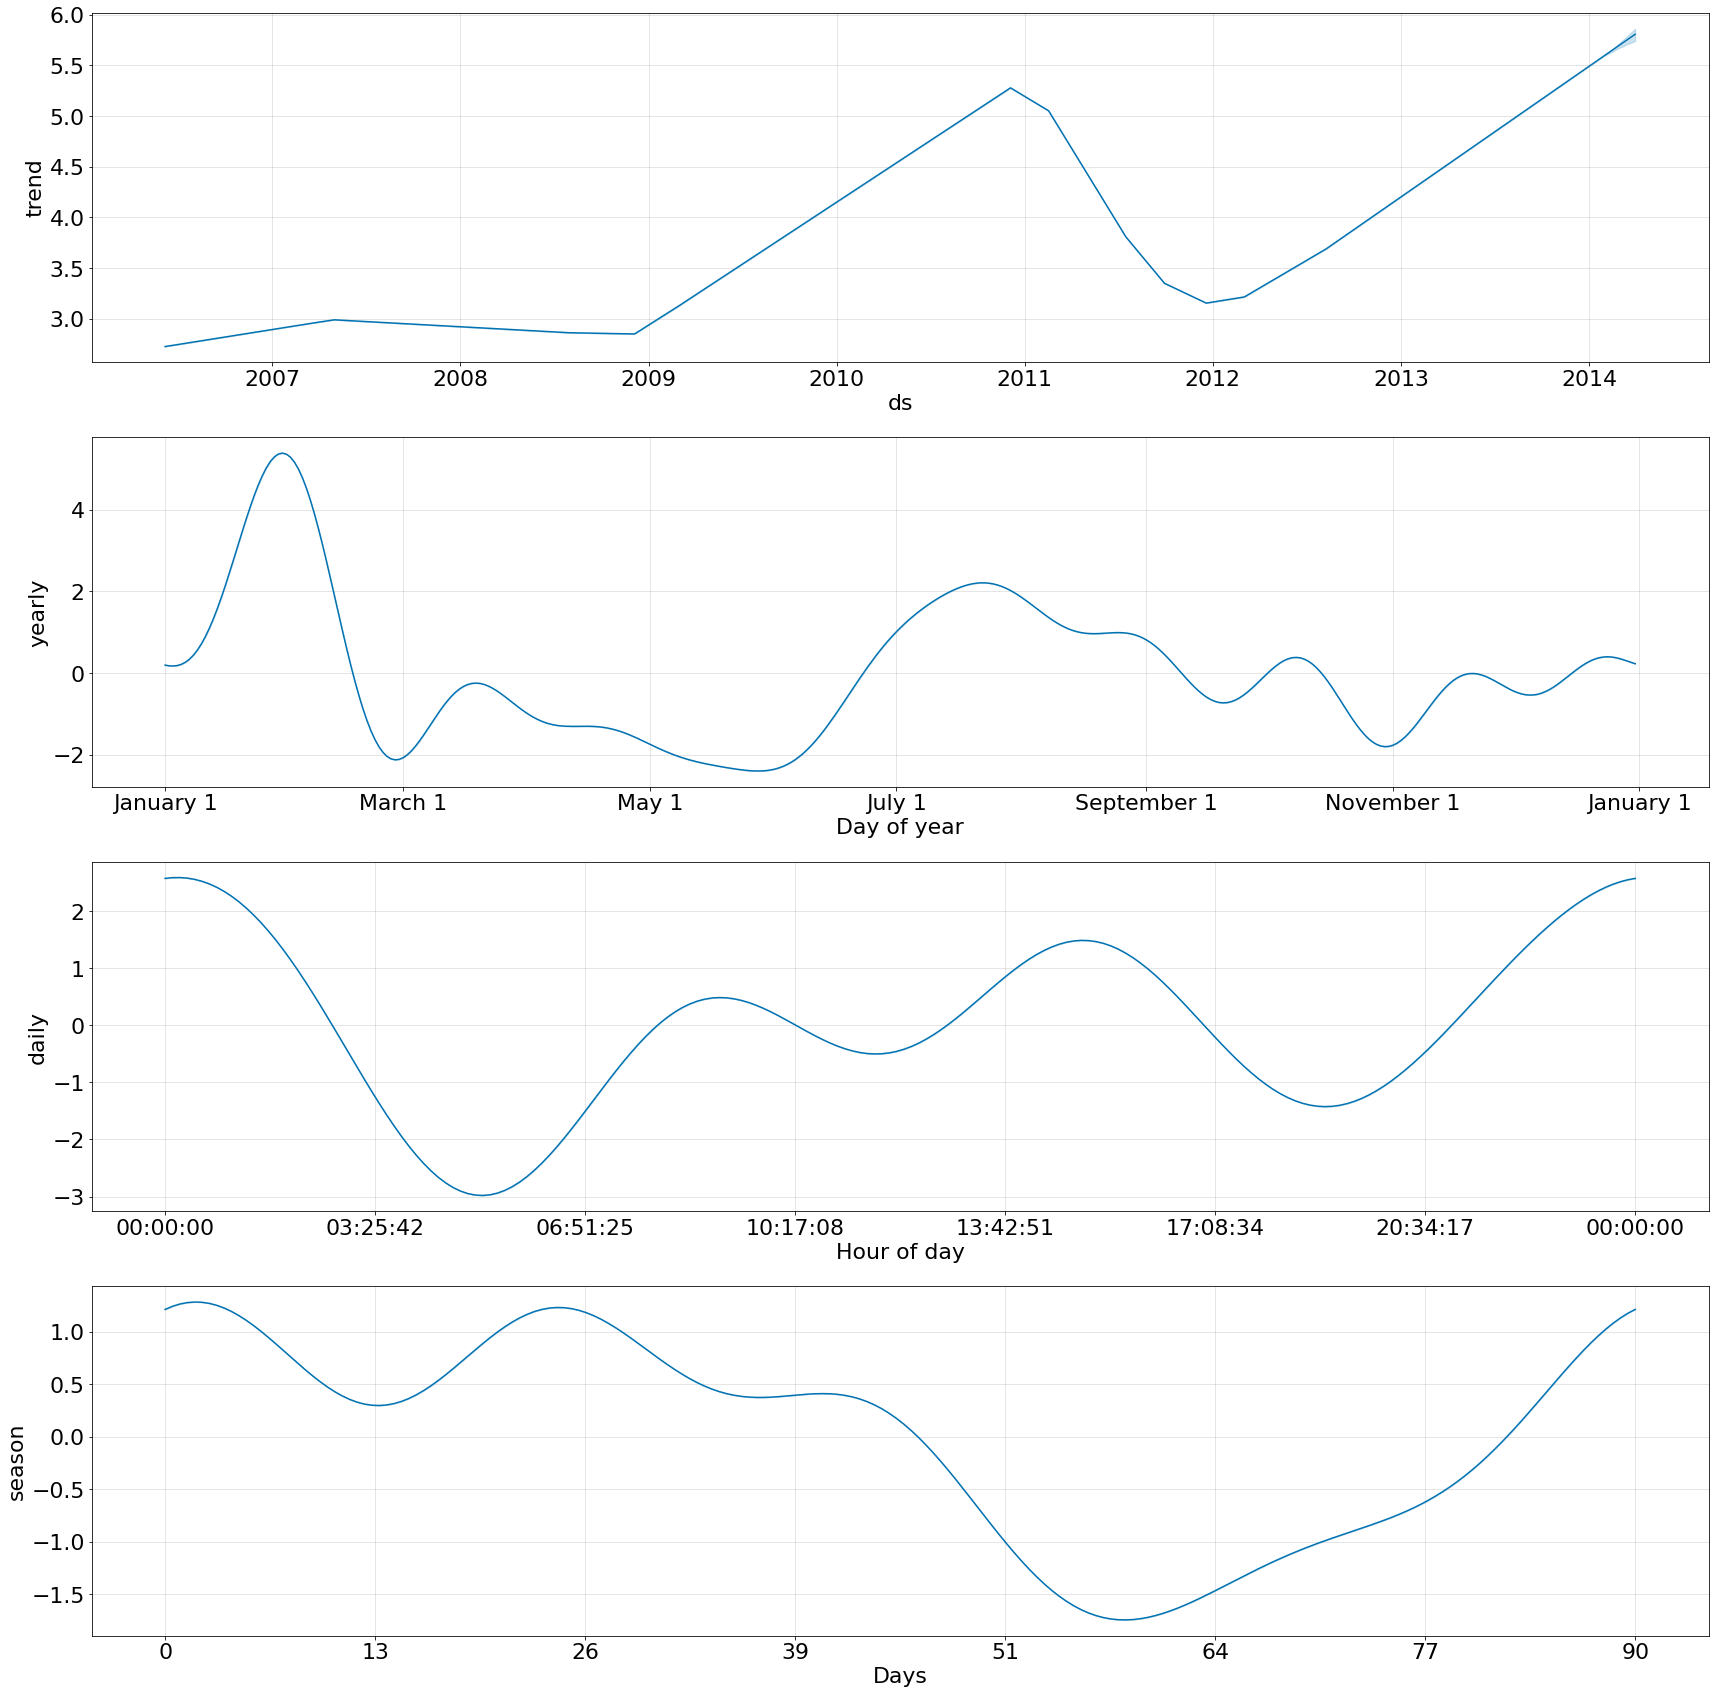

In [150]:
fig2= m.plot_components(forecast,figsize = (24,24))

In [151]:
from prophet.plot import plot_plotly, plot_components_plotly
plot_plotly(m, forecast)